****************************************************************
# Machine Learning-based Event Selection
****************************************************************

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, mixture
import cait as ai

In [2]:
et = ai.EvaluationTools()

In [3]:
path = 'test_data/'
fnames = ['labeled_001']
filepath = ['{}{}.h5'.format(path, f) for f in fnames]

In [4]:
channel = 0

In [5]:
# get features from file
dh = ai.DataHandler()
dh.set_filepath(path_h5=path,
                fname=fnames[0],
                appendix=False)

DataHandler Instance created.


In [6]:
features = dh.get('events', 'pca_projection')[0]

In [7]:
et.add_events_from_file(file=filepath[0],
                        channel=channel,
                        which_data=features,
                        )

In [8]:
#et.set_data(features)

In [9]:
et.split_test_train(test_size=0.60)

In [10]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=7)

In [11]:
X_train = et.get_train_features()
y_train = et.get_train_label_nbrs()

In [12]:
clf_rf.fit(X_train, 
           y_train)

RandomForestClassifier(criterion='entropy', max_depth=7)

In [13]:
et.add_prediction(pred_method='RFC', 
                  pred=clf_rf.predict(et.features), 
                  true_labels=True)

In [14]:
clf_svm = svm.SVC()

In [15]:
clf_svm.fit(X_train, 
            y_train)

SVC()

In [16]:
et.add_prediction(pred_method='SVM', 
                  pred=clf_svm.predict(et.features), 
                  true_labels=True)

In [17]:
bgmm = mixture.BayesianGaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                                           covariance_type='full').fit(et.features)

In [18]:
bgmm_pred = bgmm.predict(et.features)
et.add_prediction(pred_method='BGMM', 
                  pred=bgmm_pred)

In [19]:
gmm = mixture.GaussianMixture(n_components=len(np.unique(et.label_nbrs)),
                              covariance_type='full').fit(et.features)
gmm_pred = gmm.predict(et.features)
et.add_prediction(pred_method='GMM', pred=gmm_pred)

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


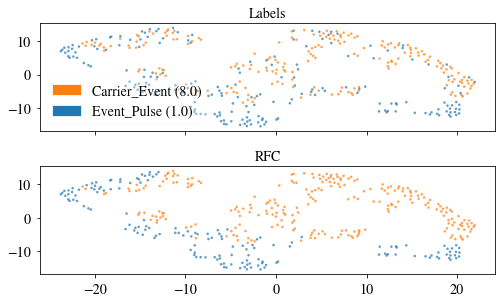

In [20]:
et.plt_pred_with_tsne(pred_methods=['RFC'], plt_what='all', verb=True)

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


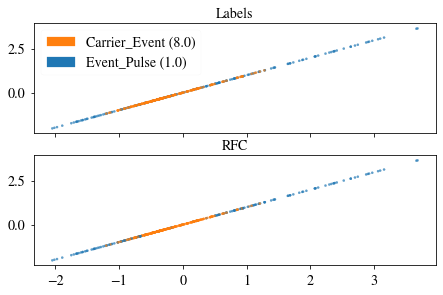

In [21]:
et.plt_pred_with_pca(pred_methods=['RFC'], xy_comp=(0,1), plt_what='all', verb=True)

-------------------------------------------------------------------------
Hovering over an event shows you the event number.
When clicking on a single event a window with its timeseries is opened.
Hovering over a a single event and pressing 'm' also opnes the timeseries
of this event and adds the calculated mainparameters to the plot.
-------------------------------------------------------------------------


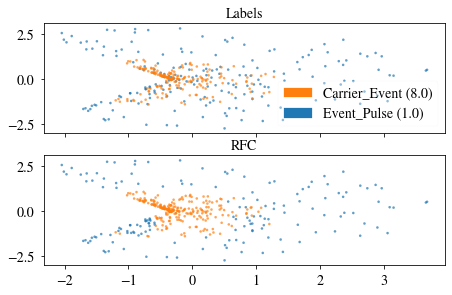

In [22]:
et.plt_pred_with_pca(pred_methods=['RFC'], plt_what='all', verb=True)

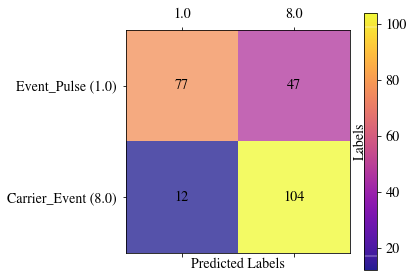

In [23]:
et.confusion_matrix_pred('SVM', what='test', rotation_xticklabels=0, force_xlabelnbr=True, figsize= (6,4))

In [ ]:
# include the predictions in the HDF5 file